**Using Lime with Pytorch**

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

Load our test image and see how it looks.

In [2]:
import gdown
url = 'https://drive.google.com/u/1/uc?id=1rcBLqE5szdu_SMC2TKmvxe7LquG9rSSL&export=download'#'https://drive.google.com/u/1/uc?id=1AnmIU4VOj0ylgdW_v2FLb9CyZHrAx5SO&export=download'
output = "data.zip"
gdown.download(url, output)

import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

file_path = "data.zip"
zip_list(file_path)

Downloading...
From: https://drive.google.com/u/1/uc?id=1rcBLqE5szdu_SMC2TKmvxe7LquG9rSSL&export=download
To: /content/data.zip
100%|██████████| 1.89M/1.89M [00:00<00:00, 128MB/s]


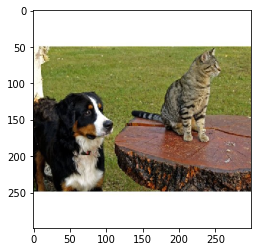

In [25]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./data/dogs.png').resize((299,299),0)
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [4]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 available in Pytorch.

In [5]:
model = models.inception_v3(pretrained=True)

Load label texts for ImageNet predictions so we know what model is predicting

In [6]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

Get the predicition for our image.

In [7]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [8]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.9383059, 239, 'Bernese_mountain_dog'),
 (0.037745487, 241, 'EntleBucher'),
 (0.022033153, 240, 'Appenzeller'),
 (0.0018301582, 238, 'Greater_Swiss_Mountain_dog'),
 (1.5927506e-05, 214, 'Gordon_setter'))

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [9]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [10]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [11]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

239

In [12]:
!pip install lime

Import lime and create explanation for this prediciton.

In [13]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
image_list = []
for i in range(25,501,25):
  image_list.append(explainer.explain_instance(np.array(pill_transf(img)), batch_predict, top_labels=5, hide_color=0,num_samples=i))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction

In [14]:
from skimage.segmentation import mark_boundaries

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


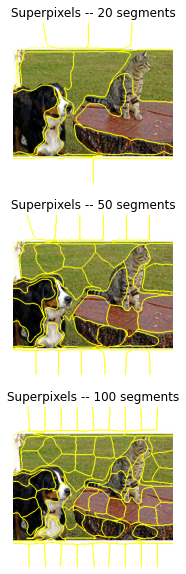

In [28]:
#顯示superpixels
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import cv2 as cv

# load the image and convert it to a floating point data type
image = img

fig = plt.figure()
fig.set_figheight(10)
# loop over the number of segments
for numSegments, i in ((20, 1), (50, 2), (100, 3)):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(image, n_segments = numSegments, sigma = 5)

	# show the output of SLIC
	ax = fig.add_subplot(3, 1, i)
	ax.set_title("Superpixels -- %d segments" % (numSegments))
	ax.imshow(mark_boundaries(image, segments))
	plt.axis("off")

# show the plots
plt.show()

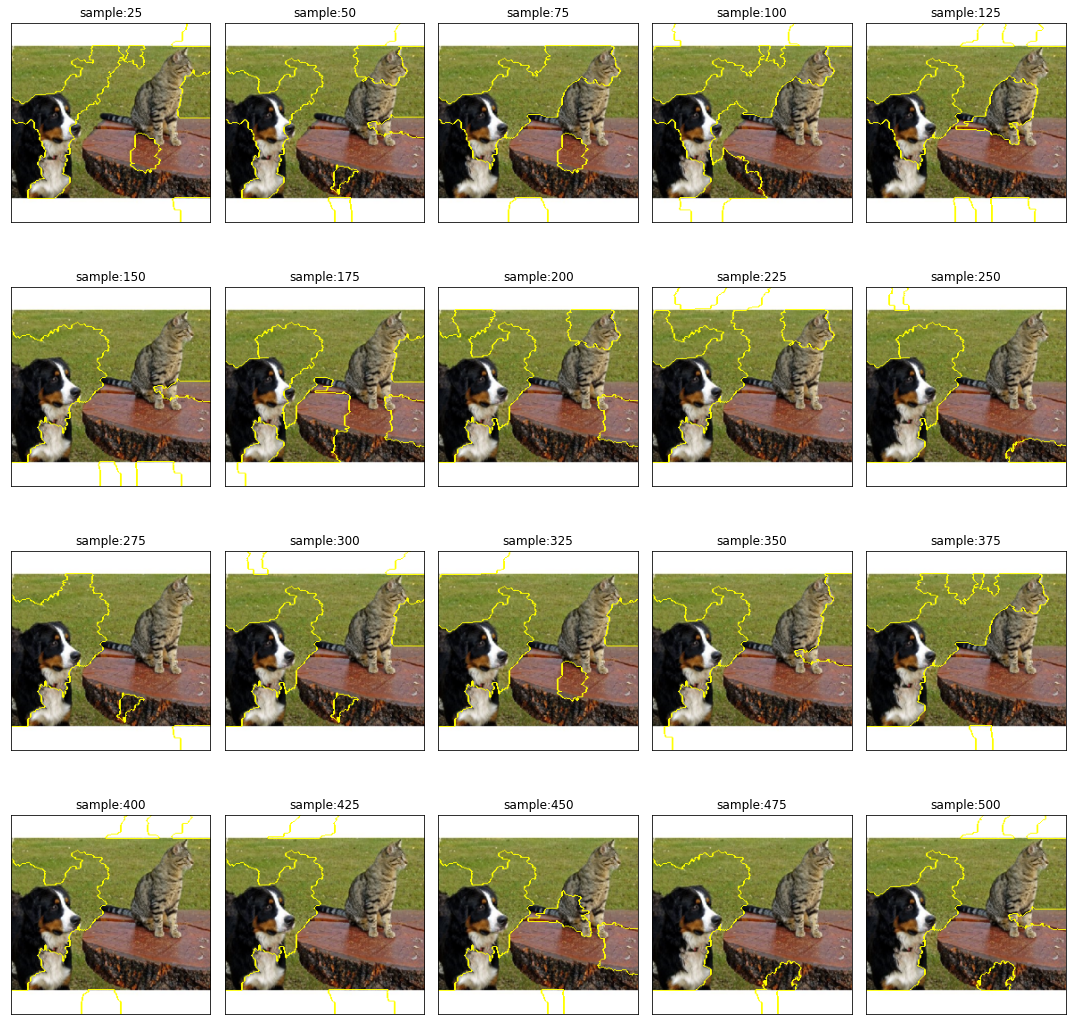

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

row = 4
col = 5

fig, ax = plt.subplots(nrows=row, ncols=col, sharex='all', sharey='all', ) # 一张图片有5行5列个子图
fig.set_figheight(15)
fig.set_figwidth(15)
ax = ax.flatten()

for idx,data in enumerate(image_list):
  if idx == 20:
    break
  temp, mask = data.get_image_and_mask(data.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
  img = mark_boundaries(temp/255.0, mask)
  #img = cv2.resize(img,(100,100))
  ax[idx].imshow(img)
  ax[idx].set_title("sample:"+ str(idx * 25 + 25))
  ax[0].set_xticks([])
  ax[0].set_yticks([])

plt.tight_layout()  # 自动紧凑布局
plt.show()


Let's turn on areas that contributes against the top prediction.

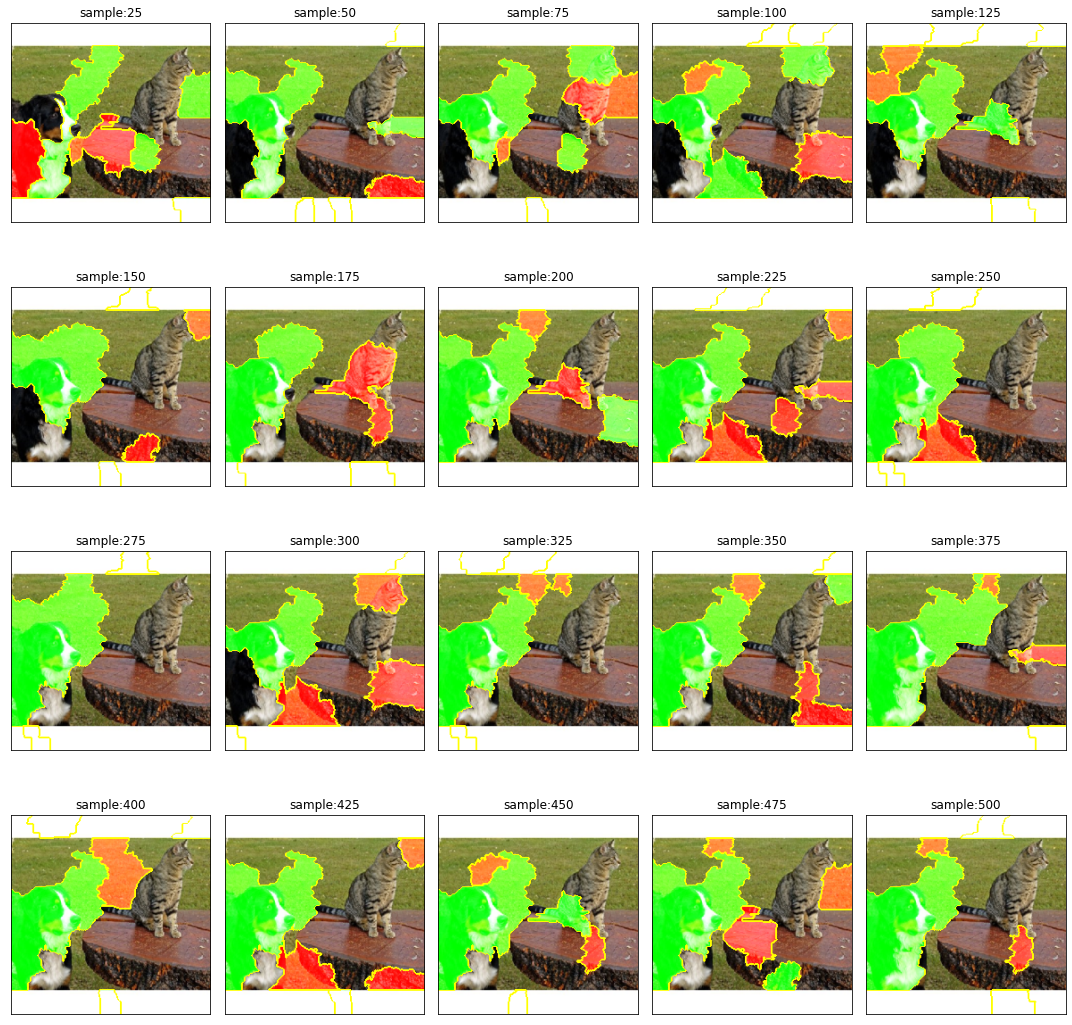

In [16]:
row = 4
col = 5

fig, ax = plt.subplots(nrows=row, ncols=col, sharex='all', sharey='all', ) # 一张图片有5行5列个子图
fig.set_figheight(15)
fig.set_figwidth(15)
ax = ax.flatten()

for idx,data in enumerate(image_list):
  if idx == 20:
    break
  temp, mask = data.get_image_and_mask(data.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  img = mark_boundaries(temp/255.0, mask)
  #img = cv2.resize(img,(100,100))
  ax[idx].imshow(img)
  ax[idx].set_title("sample:"+ str(idx * 25 + 25))
  ax[0].set_xticks([])
  ax[0].set_yticks([])

plt.tight_layout()  # 自动紧凑布局
plt.show()

In [17]:
img = get_image('./data/dogs.png')
exp = explainer.explain_instance(np.array(pill_transf(img)), batch_predict, top_labels=5, hide_color=0,num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

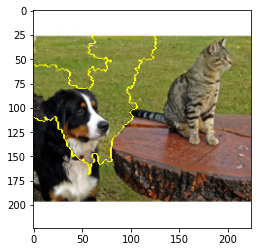

In [18]:
temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

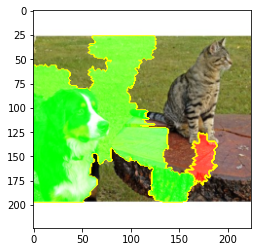

In [19]:
temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [22]:
import os 
path = 'data/picture/'
na = os.listdir(path)

explainer = lime_image.LimeImageExplainer()
image_list = []

for idx, n in enumerate(na):
  if idx >= 10:
    break
  p = path + n
  img = Image.open(p)
  img = img.convert('RGB').resize((299,299),0)
  image_list.append(explainer.explain_instance(np.array(pill_transf(img)), batch_predict, top_labels=5, hide_color=0,num_samples=1000))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

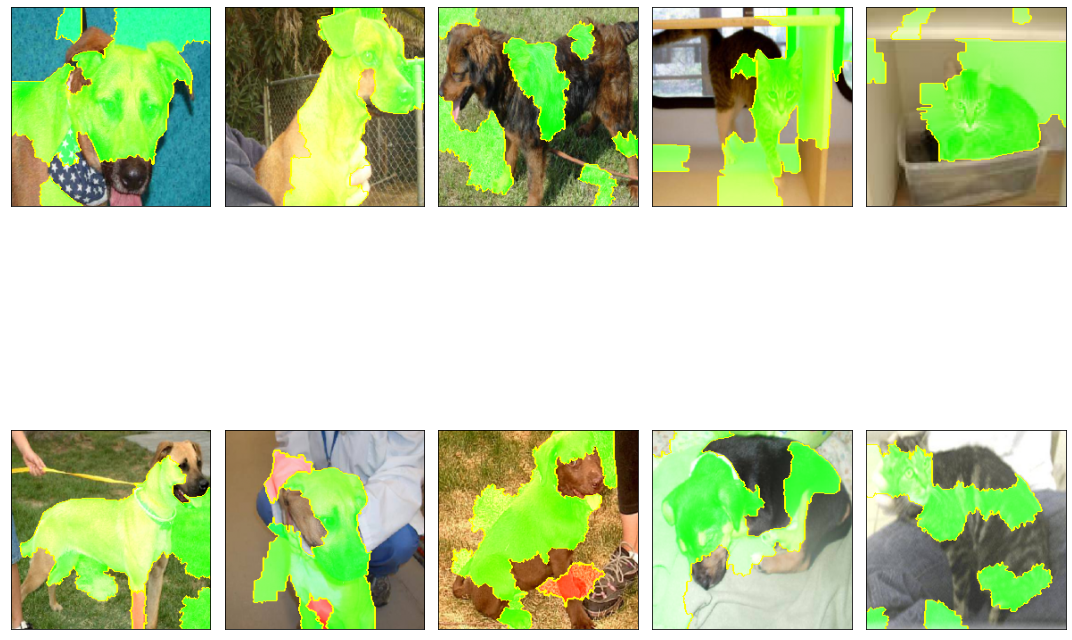

In [23]:
row = 2
col = 5

fig, ax = plt.subplots(nrows=row, ncols=col, sharex='all', sharey='all', ) # 一张图片有5行5列个子图
fig.set_figheight(15)
fig.set_figwidth(15)
ax = ax.flatten()

for idx,data in enumerate(image_list):
  if idx == 10:
    break
  temp, mask = data.get_image_and_mask(data.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  img = mark_boundaries(temp/255.0, mask)
  #img = cv2.resize(img,(100,100))
  ax[idx].imshow(img)
  ax[0].set_xticks([])
  ax[0].set_yticks([])

plt.tight_layout()  # 自动紧凑布局
plt.show()